In [2]:
from PIL import Image
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import sys
from torchsummary import summary
import cv2



In [3]:
import ipyvolume as ipv

def visualize_3D_points_in_jupyter(points_3D, size=2, marker="sphere"):
    # Assuming points_3D is a N x 3 numpy array
    x = points_3D[:, 0]
    y = points_3D[:, 1]
    z = points_3D[:, 2]

    ipv.quickscatter(x, y, z, size=size, marker=marker)
    ipv.show()

In [6]:
repo_path = '/workspace/stereo-transformer'
pretrained_weight_path = '../../PretrainedWeights/kitti_finetuned_model.pth.tar'
sys.path.append(repo_path) # add relative path

In [7]:
from module.sttr import STTR
from dataset.preprocess import normalization, compute_left_occ_region
from utilities.misc import NestedTensor, batched_index_select

def load_STTR_model(repo_path, pretrained_weight_path):
    from module.sttr import STTR
    from dataset.preprocess import normalization, compute_left_occ_region
    from utilities.misc import NestedTensor

    # Default parameters
    args = type('', (), {})() # create empty args
    args.channel_dim = 128
    args.position_encoding='sine1d_rel'
    args.num_attn_layers=6
    args.nheads=8
    args.regression_head='ot'
    args.context_adjustment_layer='cal'
    args.cal_num_blocks=8
    args.cal_feat_dim=16
    args.cal_expansion_ratio=4


    model = STTR(args).cuda().eval()

    # Load the pretrained model
    model_file_name = pretrained_weight_path
    checkpoint = torch.load(model_file_name)
    pretrained_dict = checkpoint['state_dict']
    model.load_state_dict(pretrained_dict, strict=False) # prevent BN parameters from breaking the model loading
    print("Pre-trained model successfully loaded.")
    
    return model

In [5]:
dataset_dir_path = '/workspace/Temp/'
basedir = dataset_dir_path
date = '2011_09_26'
drive = '0005'

In [6]:
#!pip install pykitti
import pykitti

# Load the data
# `frames` argument can be used to load specific frames, e.g., range(0, 50, 5)
data = pykitti.raw(basedir, date, drive, frames=range(0, 100))

# Load stereo images
left_images = [np.array(image) for image in data.cam2]
right_images = [np.array(image) for image in data.cam3]

# Load point clouds
# Each point cloud is a Nx4 matrix - the final column is reflectance
point_clouds = [np.array(pc) for pc in data.velo]

left_prj, right_prj = data.calib.P_rect_20, data.calib.P_rect_30

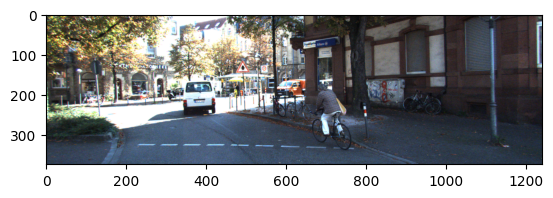

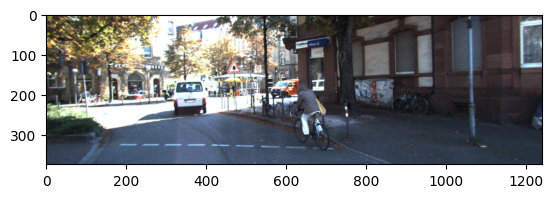

In [7]:
data_idx = 30

plt.figure(1)
plt.imshow(left_images[data_idx])
plt.figure(2)
plt.imshow(right_images[data_idx])
plt.show()

In [8]:
visualize_3D_points_in_jupyter(point_clouds[data_idx], size=5, marker='box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [9]:
import torch
print(torch.cuda.is_available())


True


In [10]:
model = load_STTR_model(repo_path, pretrained_weight_path)

Pre-trained model successfully loaded.


In [11]:
def STTR_input_factory(left_img, right_img):
    # donwsample attention by stride of 3
    left = left_img
    right = right_img
    h, w, _ = left.shape
    bs = 1
    
    downsample = 3
    col_offset = int(downsample / 2)
    row_offset = int(downsample / 2)
    sampled_cols = torch.arange(col_offset, w, downsample)[None,].expand(bs, -1).cuda()
    sampled_rows = torch.arange(row_offset, h, downsample)[None,].expand(bs, -1).cuda()

    input_data = {'left': left, 'right':right}
    input_data = normalization(**input_data)

    # build NestedTensor
    input_data = NestedTensor(input_data['left'].cuda()[None,],input_data['right'].cuda()[None,], sampled_cols=sampled_cols, sampled_rows=sampled_rows)
    return input_data
    

In [12]:
idx = 50

input_data = STTR_input_factory(left_images[idx], right_images[idx])

In [13]:
for layer in model._modules:
    print(layer)

backbone
tokenizer
pos_encoder
transformer
regression_head


In [16]:
x  = input_data
bs, _, h, w = x.left.size()
feat = model.backbone(x)
tokens = model.tokenizer(feat)
pos_enc = model.pos_encoder(x)
# separate left and right
feat_left = tokens[:bs]
feat_right = tokens[bs:]  # NxCxHxW
# downsample
if x.sampled_cols is not None:
    feat_left = batched_index_select(feat_left, 3, x.sampled_cols)
    feat_right = batched_index_select(feat_right, 3, x.sampled_cols)
if x.sampled_rows is not None:
    feat_left = batched_index_select(feat_left, 2, x.sampled_rows)
    feat_right = batched_index_select(feat_right, 2, x.sampled_rows)
attn_weight = model.transformer(feat_left, feat_right, pos_enc)

In [17]:
attn_weight.shape

torch.Size([1, 125, 414, 414])

In [18]:
with torch.no_grad():
    output = model(input_data)

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


RuntimeError: CUDA out of memory. Tried to allocate 1.28 GiB (GPU 0; 23.65 GiB total capacity; 21.02 GiB already allocated; 294.12 MiB free; 22.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [19]:
disp_map = output['disp_pred'].data.cpu().numpy()[0]
occ_map = output['occ_pred'].data.cpu().numpy()[0] > 0.5
disp_map[occ_map] = 0.0

NameError: name 'output' is not defined

In [ ]:
def convert_disp_to_depth_map(disp_map, P_left, P_right, cutoff_thresh = 0.1):
    f_left = P_left[0, 0]
    f_right = P_right[0, 0]
    b = P_right[0, 2] / f_right
 
    depth_map = np.zeros_like(disp_map)
    for (i, j), disp in np.ndenumerate(disp_map):
        if abs(disp) < cutoff_thresh:
            depth_map[i][j] = -1
        else:
            depth_map[i][j] = (f_left * b) / disp
    return depth_map

In [ ]:
# culling
disp_map = disp_map[:350, 100:1100]


plt.figure(1)
plt.imshow(disp_map)


depth_map = convert_disp_to_depth_map(disp_map, left_prj, right_prj, 0.1)

plt.figure(2)
plt.imshow(depth_map)

In [ ]:
import cv2

def disparity_to_3D_points(left_prj, right_prj, disparity):
    """
    Convert disparity map to 3D points using the given projection matrices.

    Parameters:
    - left_prj: 3x4 numpy array representing the left rectified projection matrix.
    - right_prj: 3x4 numpy array representing the right rectified projection matrix.
    - disparity: 2D numpy array representing the disparity map.

    Returns:
    - 3D numpy array with shape (H, W, 3) representing the 3D points.
    """
    # Compute Q matrix from projection matrices
    f = left_prj[0, 0]  # Focal length, assuming it's the same for both cameras after rectification
    T = right_prj[0, 3] / f  # Baseline

    Q = np.array([
        [1, 0, 0, -0.5 * disparity.shape[1]],
        [0, -1, 0, 0.5 * disparity.shape[0]],
        [0, 0, 0, -f],
        [0, 0, -1 / T, 0]
    ])

    # Reproject image to 3D
    points_3D = cv2.reprojectImageTo3D(disparity, Q)
    return points_3D

In [ ]:
points_3D = disparity_to_3D_points(left_prj, right_prj, disp_map)

# Mask out points where disparity is 0 (or less) as they're likely invalid
mask = disp_map > 0
valid_points_3D = points_3D[mask]

print(valid_points_3D.shape)

plt.figure(1)
plt.imshow(left_images[idx])
plt.figure(2)
plt.imshow(disp_map)
plt.show()

visualize_3D_points_in_jupyter(valid_points_3D, size=1, marker='sphere')

In [15]:
idx = 8
input_data = STTR_input_factory(left_images[idx], right_images[idx])

with torch.no_grad():
    output = model(input_data)
    
disp_map = output['disp_pred'].data.cpu().numpy()[0]
occ_map = output['occ_pred'].data.cpu().numpy()[0] > 0.5
disp_map[occ_map] = 0.0

# culling
disp_map = disp_map[:350, 100:1100]

points_3D = disparity_to_3D_points(left_prj, right_prj, disp_map)

# Mask out points where disparity is 0 (or less) as they're likely invalid
mask = disp_map > 0
valid_points_3D = points_3D[mask]

print(valid_points_3D.shape)

plt.figure(1)
plt.imshow(left_images[idx])
plt.figure(2)
plt.imshow(disp_map)
plt.show()

visualize_3D_points_in_jupyter(valid_points_3D, size=1, marker='sphere')

RuntimeError: CUDA out of memory. Tried to allocate 462.00 MiB (GPU 0; 23.65 GiB total capacity; 10.88 GiB already allocated; 176.56 MiB free; 11.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
idx = 99
input_data = STTR_input_factory(left_images[idx], right_images[idx])

with torch.no_grad():
    output = model(input_data)
    
disp_map = output['disp_pred'].data.cpu().numpy()[0]
occ_map = output['occ_pred'].data.cpu().numpy()[0] > 0.5
disp_map[occ_map] = 0.0

# culling
disp_map = disp_map[:350, 100:1100]

points_3D = disparity_to_3D_points(left_prj, right_prj, disp_map)

# Mask out points where disparity is 0 (or less) as they're likely invalid
mask = disp_map > 0
valid_points_3D = points_3D[mask]

print(valid_points_3D.shape)

plt.figure(1)
plt.imshow(left_images[idx])
plt.figure(2)
plt.imshow(disp_map)
plt.show()

visualize_3D_points_in_jupyter(valid_points_3D, size=1, marker='sphere')

In [ ]:
model.transformer

In [ ]:
model.pos_encoder

In [ ]:
model.backbone

In [ ]:
model

In [ ]:
torch.load("../../PretrainedWeights/" + "/kitti_multicam_flospdepth_crp_stereodepth_cascadecls_2080ti_mIoU12.8.ckpt")

In [ ]:
model

In [ ]:
def count_parameters(model):
    total_params = 0
    for param in model.parameters():
        total_params += np.prod(param.size())
    return total_params

# Example Usage
total_parameters = count_parameters(model)

# Convert to millions and format the string
params_in_millions = total_parameters / 1_000_000
print(f"Total Parameters in Model: {params_in_millions:.3f}M")